In [1]:
import os
import pandas as pd
import numpy as np
from ast import literal_eval
%matplotlib inline
import matplotlib.pyplot as plt
from shutil import copyfile
from utils.visualization_utils import generic_plot, Curve, format_xtick, generic_sub_plot, Plot
from utils.data_utils import select_data
from learning_models.torch_sir import SirEq
import torch

In [2]:
exp_dir = os.path.join("regioni", "torch_sir_validation_grid_search")
best_path = os.path.join(os.getcwd(), exp_dir, "best")
if not os.path.exists(best_path):
    os.mkdir(best_path)

In [3]:
regions = [
    "Sardegna", 
    "P.A. Bolzano",
    "Basilicata",
    "Campania",
    "Friuli Venezia Giulia",
    "Lombardia",
    "Piemonte"
]

In [4]:
def get_scores_path(region):
    return os.path.join(exp_dir, region, "scores.csv")

def get_df(region):
    path = get_scores_path(region)
    df = pd.read_csv(path, sep="\t")
    return df[(df.use_alpha == False)]
    
def get_best_exp(df):
    return df[df.val_risk == df.val_risk.min()]

def print_best_exp_info(df):
    best_exp = get_best_exp(df)
    best_exp_name = best_exp.name.values[0]
    print(best_exp.val_risk)
    print(best_exp.test_risk)
    print(best_exp.dataset_risk)

    print(best_exp_name)

In [5]:
def compute_r0(df, t):
    df["r0_t" + str(t)] = df["final_beta_t" + str(t)] / df["final_gamma_t0"]
    
def get_list_from_column(df, raw_pos, column, max_size):
    col_val = df[column].iloc[raw_pos]
    x = literal_eval(col_val)
    return x +  [-1.0]*(max_size - len(x))

def get_res_parameters(scores_df, params=("beta", "gamma", "delta")):
    max_len = scores_df["train_size"].max()
    p_columns = ["final_" + p + "_t" + str(i) for p in params for i in range(max_len)]
    score_columns = list(set(scores_df.columns) - set(params))
    #     params_df.at[:, score_columns] = scores_df.loc[:, score_columns] # copies everything in the first columns
    
    rows = []
    for i in range(scores_df.shape[0]):
        # create rows
        values = []
        for p in params:
            val = get_list_from_column(scores_df, i, p, max_len)
            values.extend(val)
        rows.append(list(scores_df.iloc[i][score_columns]) + values)
        
    
    params_df = pd.DataFrame(rows, columns=score_columns + p_columns)
    
    for p in p_columns:
        #print(params_df[p])
        params_df.loc[params_df[p] == -1, p] = None

    for t in range(max_len):
        compute_r0(params_df, t)
    
    return params_df, p_columns

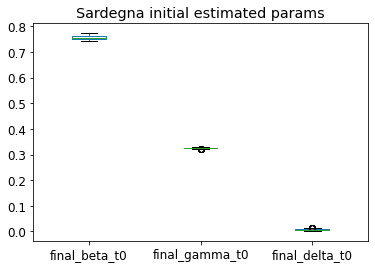

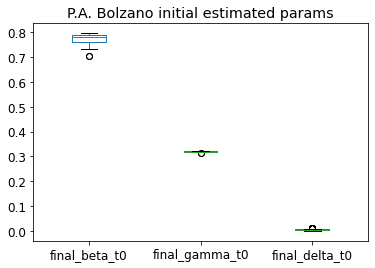

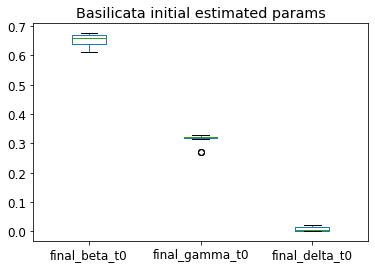

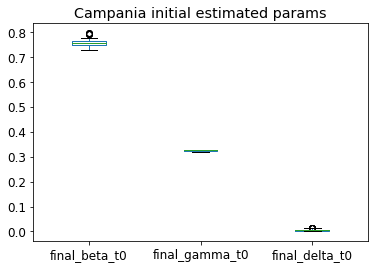

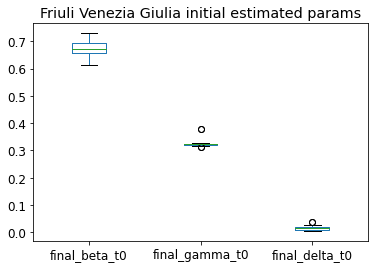

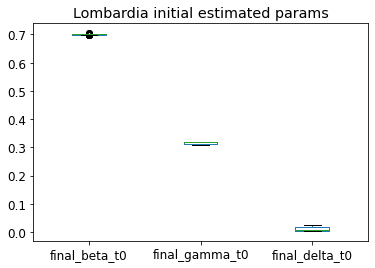

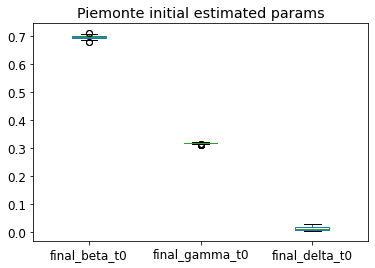

In [6]:
for region in regions:
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    params_df[["final_beta_t0", "final_gamma_t0", "final_delta_t0"]].plot.box(title=region +" initial estimated params")

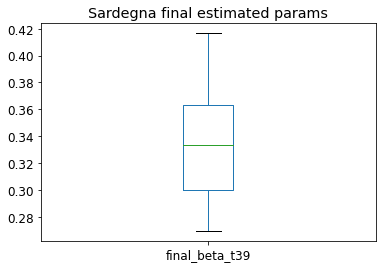

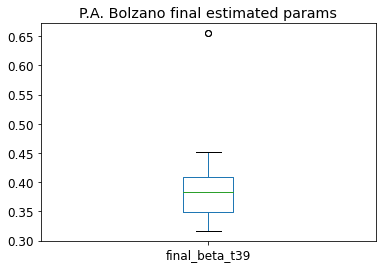

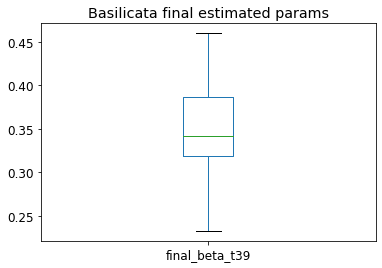

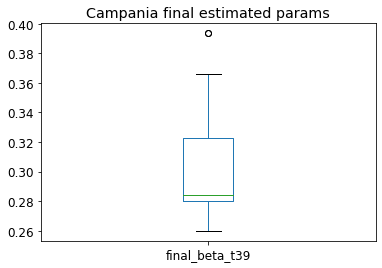

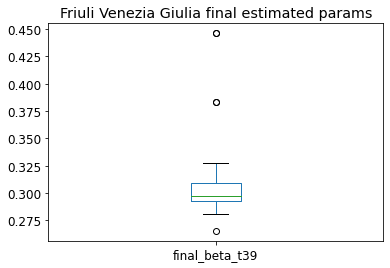

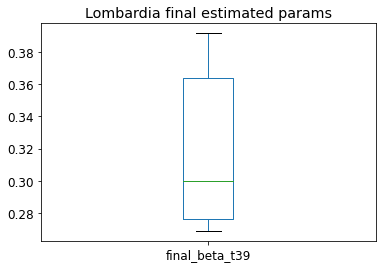

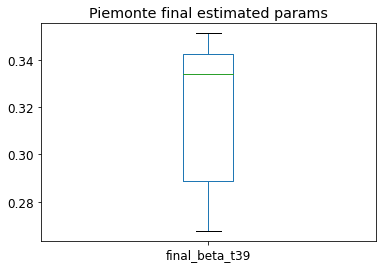

In [7]:

for region in regions:
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    params_df[["final_beta_t39"]].plot.box(title=region + " final estimated params")

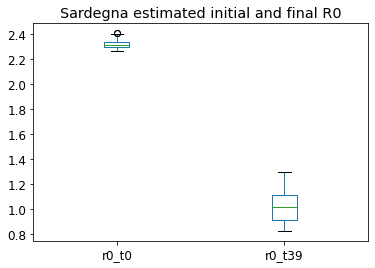

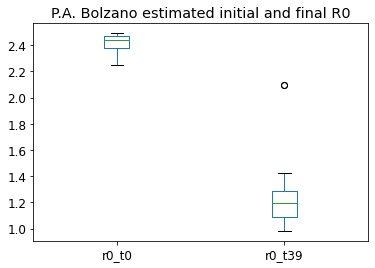

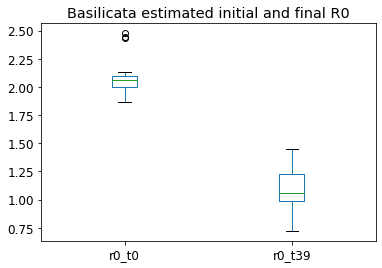

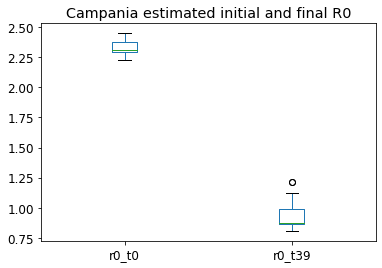

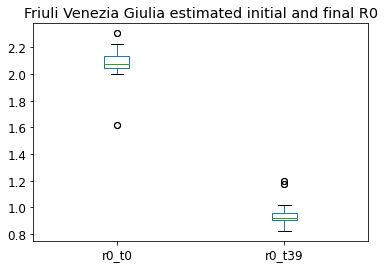

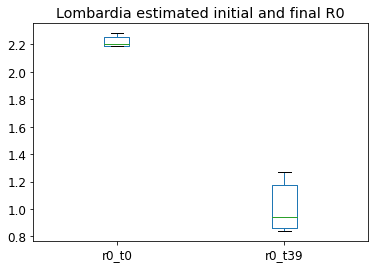

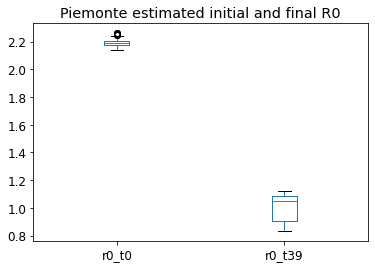

In [8]:
for region in regions:
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    params_df[["r0_t0", "r0_t39"]].plot.box(title=region +" estimated initial and final R0")

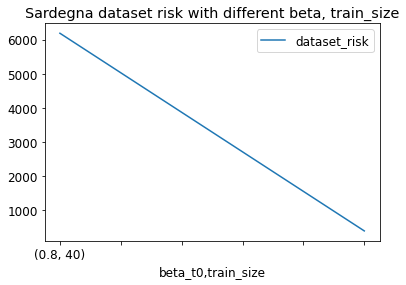

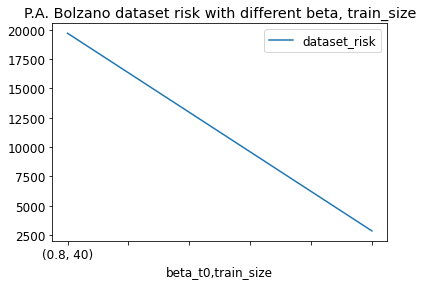

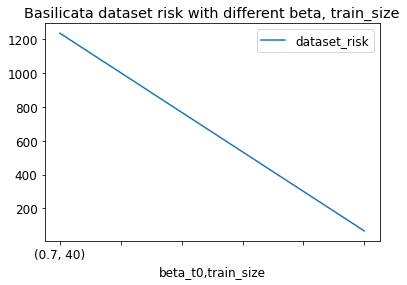

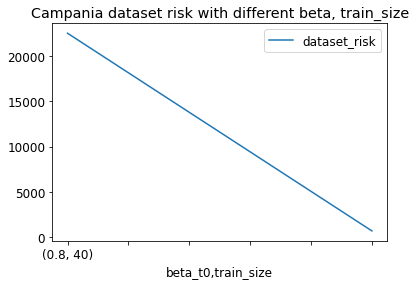

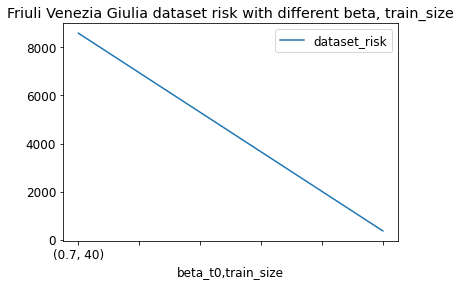

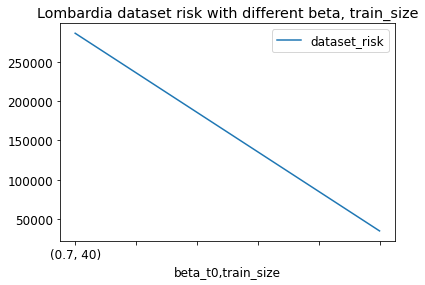

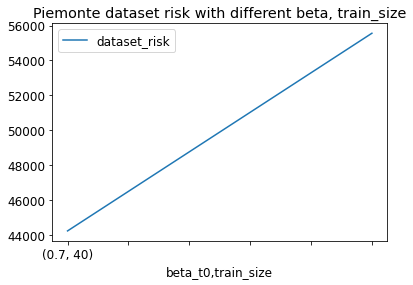

In [9]:
for region in regions:
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    params_df.groupby(["beta_t0","train_size"])[["dataset_risk"]].mean().plot(title=region + " dataset risk with different beta, train_size", legend=True)

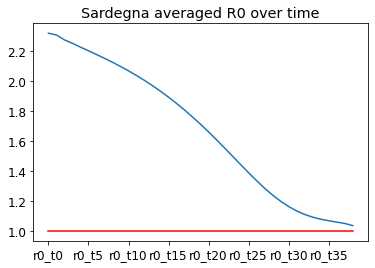

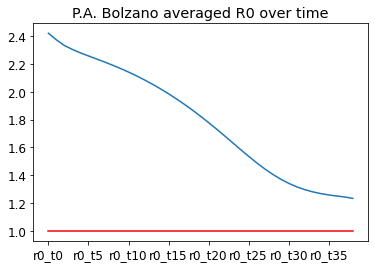

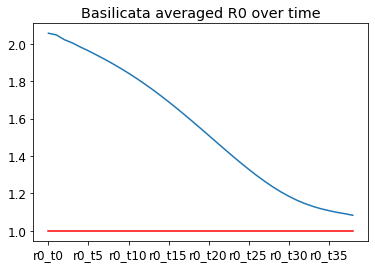

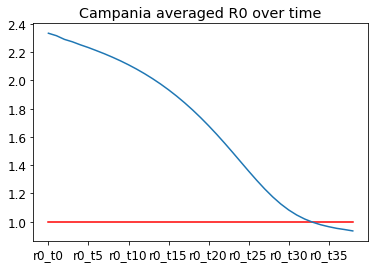

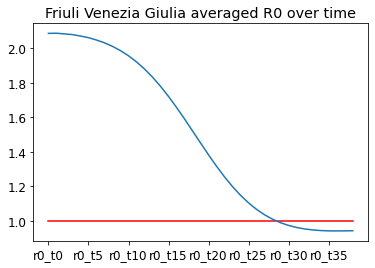

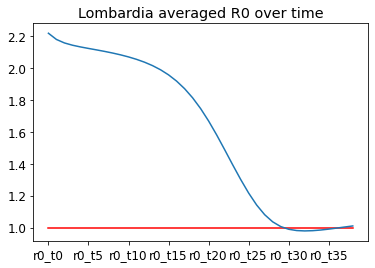

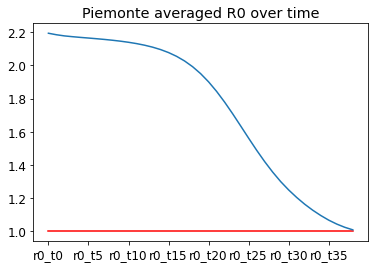

In [10]:
for region in regions:
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    fig, ax = plt.subplots()
    r0_cols = ["r0_t"+ str(t) for t in range(39)]
    ax.plot([1.0]*len(r0_cols), '-r')
    params_df[r0_cols].mean().plot(ax=ax, title=region + " averaged R0 over time")

S_b0.8_g0.3_d0.02_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts45_vl10_st_der100000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
P_b0.8_g0.3_d0.02_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts45_vl10_st_der20000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
B_b0.7_g0.3_d0.03_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts45_vl20_st_der10000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
C_b0.8_g0.3_d0.01_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts45_vl10_st_der20000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
F_b0.7_g0.3_d0.01_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts40_vl10_st_der10000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
L_b0.7_g0.3_d0.03_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts40_vl10_st_der20000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
P_b0.7_g0.3_d0.01_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts40_vl10_st_der20000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0


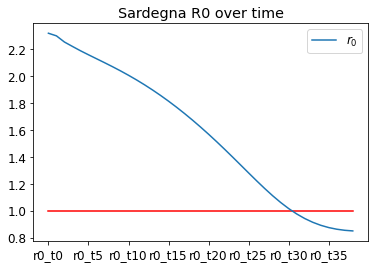

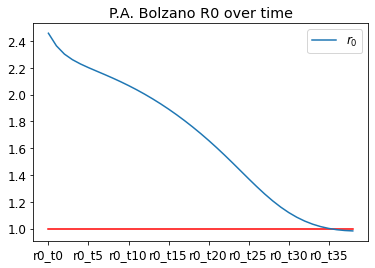

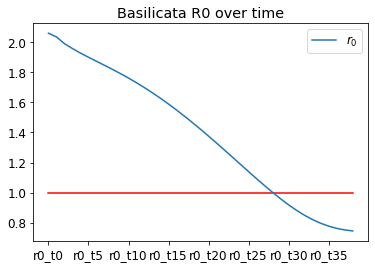

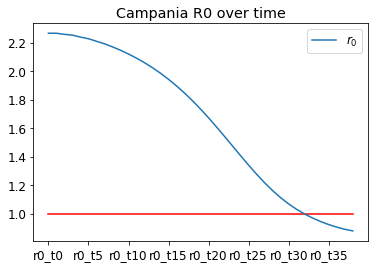

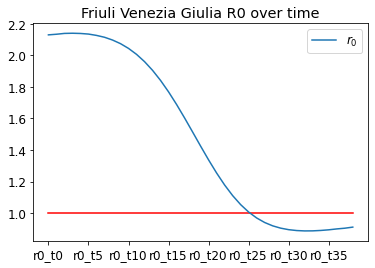

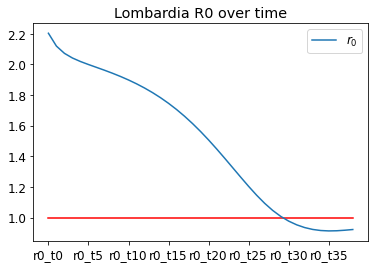

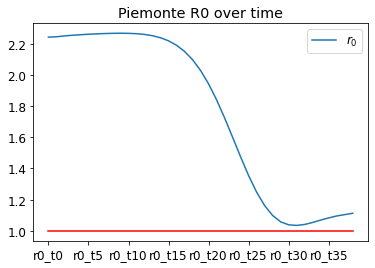

In [11]:
for region in regions:
    # R0 of single experiment
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    exp_id = params_df.val_risk.idxmin()
    print(params_df.iloc[exp_id]["name"])
    r0_cols = ["r0_t"+ str(t) for t in range(39)]
    fig, ax = plt.subplots()
    ax.plot([1.0]*len(r0_cols), '-r')
    params_df[r0_cols].iloc[exp_id].plot(ax=ax, label="$r_0$", legend=True, title=region + " R0 over time")
    plt.savefig(os.path.join(best_path, f"{region}_r0.png"), transparent=True)

In [12]:
populations = {
    "Lombardia": 1e7, 
    "Emilia-Romagna": 4.45e6, 
    "Veneto": 4.9e6, 
    "Piemonte": 4.36e6,
    "Toscana": 3.73e6, 
    "Umbria": 0.882e6, 
    "Marche": 1.525e6, 
    "Campania": 5.802e6,
    "Puglia": 1.551e6, 
    "Liguria": 4.029e6,
    "P.A. Bolzano": 5.209e5,
    "P.A. Trento": 5.414e5,
    "Valle d'Aosta": 1.257e5,
    "Sicilia": 5e6,
    "Sardegna": 1.64e6,
    "Abruzzo": 1.312e6,
    "Lazio": 5.879e6,
    "Molise": 3.05e5, 
    "Friuli Venezia Giulia": 1.215e6, 
    "Calabria": 1.947e6, 
    "Basilicata": 5.63e5
}

In [13]:
def get_target(region):
    df_path = os.path.join(os.getcwd(), "COVID-19", "dati-regioni", "dpc-covid19-ita-regioni.csv")
    area = [region]  # list(df["denominazione_regione"].unique())
    area_col_name = "denominazione_regione"  # "Country/Region"
    value_col_name = "deceduti"  # "Fatalities"
    groupby_cols = ["data"]  # ["Date"]
    x_target, w_target = select_data(df_path, area, area_col_name, value_col_name, groupby_cols, file_sep=",")
    _, y_target = select_data(df_path, area, area_col_name, "totale_positivi", groupby_cols, file_sep=",")
    _, healed = select_data(df_path, area, area_col_name, "dimessi_guariti", groupby_cols, file_sep=",")
    
    tmp_y, tmp_w, tmp_h = [], [], []
    for i in range(len(y_target)):
        if y_target[i] > 0:
            tmp_y.append(y_target[i])
            tmp_w.append(w_target[i])
            tmp_h.append(healed[i])
    y_target = tmp_y
    w_target = tmp_w
    healed = tmp_h
    return w_target, y_target, healed

    

In [14]:
for region in regions:
    df = get_df(region)
    best_exp = get_best_exp(df).iloc[0]
    beta = literal_eval(best_exp["beta"])
    gamma = literal_eval(best_exp["gamma"])
    delta = literal_eval(best_exp["delta"])
    train_size = best_exp["train_size"]
    val_len = best_exp["val_size"]
    t_inc = best_exp["t_inc"]
    use_alpha = best_exp["use_alpha"]
    population = populations[region]
    
    w_target, y_target, healed = get_target(region)
    
    val_size = min(train_size + val_len, len(w_target) - 5)  # validation on the next val_len days (or less if we have less data)
    dataset_size = len(w_target)
    exp_prefix = region + "_best"
    
    dy_params = {"t_start": 0, "t_end": train_size}
    
    # init parameters
    epsilon = y_target[0].item() / population
    epsilon_z = w_target[0].item() / population
    S0 = 1 - (epsilon + epsilon_z)
    I0 = epsilon
    S0 = S0 * population
    I0 = I0 * population
    Z0 = epsilon_z

    init_cond = (S0, I0, Z0)  # initialization of SIR parameters (Suscettible, Infected, Recovered)
    sir = SirEq(beta, gamma, delta, population, init_cond=init_cond)
    
    w_hat, y_hat, sol = sir.inference(torch.arange(dy_params["t_start"], 100, t_inc))
    
    train_slice = slice(dy_params["t_start"], int(train_size/t_inc), int(1/t_inc))
    val_slice = slice(int(train_size/t_inc), int(val_size/t_inc), int(1/t_inc))
    test_slice = slice(int(val_size/t_inc), int(dataset_size/t_inc), int(1/t_inc))
    dataset_slice = slice(dy_params["t_start"], int(dataset_size/t_inc), int(1/t_inc))

    w_hat_train, w_hat_val, w_hat_test = w_hat[train_slice], w_hat[val_slice], w_hat[test_slice]
    w_hat_dataset = w_hat[dataset_slice]
    y_hat_train, y_hat_val, y_hat_test = y_hat[train_slice], y_hat[val_slice], y_hat[test_slice]
    y_hat_dataset = y_hat[dataset_slice]

    train_risk, train_w_risk, train_y_risk, _ = sir.loss(w_hat_train, w_target[dy_params["t_start"]:train_size],
                                                         y_hat_train, y_target[dy_params["t_start"]:train_size])

    validation_risk, validation_w_risk, validation_y_risk, _ = sir.loss(w_hat_val, w_target[dy_params["t_end"]:val_size],
                                                                        y_hat_val, y_target[dy_params["t_end"]:val_size])

    test_risk, test_w_risk, test_y_risk, _ = sir.loss(w_hat_test, w_target[val_size:dataset_size],
                                                      y_hat_test, y_target[val_size:dataset_size])

    dataset_risk, _, _, _ = sir.loss(w_hat_dataset, w_target[dy_params["t_start"]:dataset_size],
                                     y_hat_dataset, y_target[dy_params["t_start"]:dataset_size])
    
    file_format = ".png"
    exp_path = best_path
    
    #initial vals
    pl_x = list(range(train_size))  # list(range(len(beta)))
    beta_pl = Curve(pl_x, sir.beta.detach().numpy(), '-g', "$\\beta$")
    gamma_pl = Curve(pl_x, [sir.gamma.detach().numpy()]*train_size, '-r', "$\gamma$")
    delta_pl = Curve(pl_x, [sir.delta.detach().numpy()]*train_size, '-b', "$\delta$")
    params_curves = [beta_pl, gamma_pl, delta_pl]
    bgd_pl_title = "$\\beta, \gamma, \delta$  ({}".format(str(region)) + str(")")
    bgd_pl_path = os.path.join(exp_path, exp_prefix + "_bcd_over_time" + file_format)
    fig = generic_plot(params_curves, bgd_pl_title, bgd_pl_path, formatter=format_xtick)
    

    # R0
    pl_x = list(range(len(beta)))
    if use_alpha:
        alpha = np.concatenate([sir.alpha(sir.get_policy_code(t)).detach().numpy().reshape(1) for t in range(len(sir.beta))], axis=0)
        r0_pl = Curve(pl_x, (alpha * sir.beta.detach().numpy())/sir.gamma.detach().numpy(), '-', label="$R_0$")
    else:
        r0_pl = Curve(pl_x, sir.beta.detach().numpy()/sir.gamma.detach().numpy(), '-', label="$R_0$")

    thresh_r0_pl = Curve(pl_x, [1.0]*len(pl_x), '-', color="magenta")

    r0_pl_title = '$R_0$  ({}'.format(str(region)) + str(")")
    r0_pl_path = os.path.join(exp_path, exp_prefix + "_r0" + file_format)

    fig = generic_plot([r0_pl, thresh_r0_pl], r0_pl_title, r0_pl_path, formatter=format_xtick)
    
    # normalize wrt population
    w_hat = w_hat[dataset_slice].detach().numpy() / population
    RES = sol.detach().numpy() / population
    print(len(RES[:,0]))
    _y = [_v / population for _v in y_target]
    _w = [_v / population for _v in w_target]
    _healed = [_v / population for _v in healed]

    # SIR dynamic
    recovered = np.array(_healed) +  np.array(_w)
    assert(len(RES[:, 0]) == len(RES[:, 1]) == len(RES[:, 2]))
    sir_len = len(RES[:, 0])
    pl_sir_x = np.array(list(range(sir_len))) * t_inc
    assert(len(_w) == len(_y) == len(_healed))
    sir_truth_len = len(_w)
    pl_sir_truth_x = np.array(list(range(sir_truth_len)))

    sir_dir_path = os.path.join(exp_path, exp_prefix + "_SIR_global" + file_format)
    # plot_sir_dynamic(RES[:, 0], RES[:, 1], RES[:, 2], area[0], sir_dir_path)
    s_fit_curve = Curve(pl_sir_x, RES[:, 0], '-g', label='$x$')
    s_truth = np.ones(len(_w))-( np.array(_y) + recovered )
    s_truth_points = Curve(pl_sir_truth_x, s_truth, '.g', label='$x$')
    s_curves = [s_fit_curve, s_truth_points]
    s_sub_pl = Plot(x_label=None, y_label="S", use_grid=True, use_legend=True, curves=s_curves, bottom_adjust=0.15, margins=0.05, formatter=format_xtick,
                    h_pos=1, v_pos=1)
    i_fit_curve = Curve(pl_sir_x, RES[:, 1], '-r', label='$y$')
    i_truth_points = Curve(pl_sir_truth_x, _y, '.r', label='$y$')
    i_curves = [i_fit_curve, i_truth_points]
    i_sub_pl = Plot(x_label=None, y_label="I", use_grid=True, use_legend=True, curves=i_curves, bottom_adjust=0.15, margins=0.05, formatter=format_xtick,
                    h_pos=1, v_pos=2)
    r_fit_curve = Curve(pl_sir_x, RES[:, 2], '-k', label='$z$')
    r_truth_points = Curve(pl_sir_truth_x, recovered, '.k', label='$z$')
    r_curves = [r_fit_curve, r_truth_points]
    r_sub_pl = Plot(x_label=None, y_label="R", use_grid=True, use_legend=True, curves=r_curves, bottom_adjust=0.15, margins=0.05, formatter=format_xtick,
                    h_pos=1, v_pos=3)
    sir_title = 'SIR  ({}'.format(region) + str(")")
    fig = generic_sub_plot([s_sub_pl, i_sub_pl, r_sub_pl], sir_title, sir_dir_path)
    
    
    # Deaths
    pl_w_hat = list(range(len(w_hat)))
    w_hat_pl = Curve(pl_w_hat, w_hat, '-', label='$w$')

    deaths_pl_title = 'Deaths  ({}'.format(str(region)) + str(")")
    deaths_pl_path = os.path.join(exp_path, exp_prefix + "_W_global" + file_format)

    fig = generic_plot([w_hat_pl], deaths_pl_title, deaths_pl_path, 'Time in days', 'Deaths')
    
    
    """
    def get_hat_list(start, end):
        return list(range(int(start/t_inc), int(end/t_inc)))
    
    
    y_fits = Curve(get_hat_list(0, train_size), RES[:train_size, 1], '-r', label='$y$ fit')
    y_val_preds = Curve(get_hat_list(train_size, val_size), RES[train_size:val_size, 1], '-r', color='darkblue', label='$y$ validation')
    y_test_preds = Curve(get_hat_list(val_size, dataset_size), RES[val_size:dataset_size, 1], '-r', color='orange', label='$y$ prediction')
    y_truth_train = Curve(list(range(train_size)), _y[:train_size], '.r', label='$\hat{y}$ fit')
    y_truth_val = Curve(list(range(train_size, val_size)), _y[train_size:val_size], '.', color="darkblue", label='$\hat{y}$ validation')
    y_truth_test = Curve(list(range(val_size, dataset_size)), _y[val_size:dataset_size], '.', color="orange", label='$\hat{y}$ prediction')
    """
    
    y_hat = RES[:,1]
    
    # Infectious Train/Test/Real
    y_fits = Curve(list(range(train_size)), y_hat[train_slice], '-r', label='$y$ fit')
    y_val_preds = Curve(list(range(train_size, val_size)), y_hat[val_slice], '-r', color='darkblue', label='$y$ validation')
    y_test_preds = Curve(list(range(val_size, dataset_size)), y_hat[test_slice], '-r', color='orange', label='$y$ prediction')
    y_truth_train = Curve(list(range(train_size)), _y[:train_size], '.r', label='$\hat{y}$ fit')
    y_truth_val = Curve(list(range(train_size, val_size)), _y[train_size:val_size], '.', color="darkblue", label='$\hat{y}$ validation')
    y_truth_test = Curve(list(range(val_size, dataset_size)), _y[val_size:dataset_size], '.', color="orange", label='$\hat{y}$ prediction')

    infected_pl_title = 'Infectious  ({}'.format(str(region)) + str(")")
    infected_pl_path = os.path.join(exp_path, exp_prefix + "_I_fit" + file_format)

    fig = generic_plot([y_fits, y_val_preds, y_test_preds, y_truth_train, y_truth_val, y_truth_test], infected_pl_title, infected_pl_path, y_label='Infectious', formatter=format_xtick)
    
    
    
    # Deaths Train/Test/Real
    w_fits = Curve(list(range(train_size)), w_hat[:train_size], '-', label='$w$ fit')
    w_val_preds = Curve(list(range(train_size, val_size)), w_hat[train_size:val_size], '-', color='darkblue', label='$w$ validation')
    w_test_preds = Curve(list(range(val_size, dataset_size)), w_hat[val_size:dataset_size], '-', color='orange', label='$w$ prediction')
    w_truth_train = Curve(list(range(train_size)), _w[:train_size], '.r', label='$\hat{w}$ fit')
    w_truth_val = Curve(list(range(train_size, val_size)), _w[train_size:val_size], '.', color="darkblue", label='$\hat{w}$ validation')
    w_truth_test = Curve(list(range(val_size, dataset_size)), _w[val_size:dataset_size], '.', color="orange", label='$\hat{w}$ prediction')

    w_pl_title = 'Deaths  ({}'.format(str(region)) + str(")")
    w_pl_path = os.path.join(exp_path, exp_prefix + "_W_fit" + file_format)

    fig = generic_plot([w_fits, w_val_preds, w_test_preds, w_truth_train, w_truth_val, w_truth_test], w_pl_title, w_pl_path, y_label="Deaths", formatter=format_xtick)

1000
1000
1000
1000
1000
1000
1000


In [15]:
for region in regions:
    df = get_df(region)
    print_best_exp_info(df)

59    7.816322
Name: val_risk, dtype: float64
59    45.925426
Name: test_risk, dtype: float64
59    14.110578
Name: dataset_risk, dtype: float64
S_b0.8_g0.3_d0.02_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts45_vl10_st_der100000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
58    3.808903
Name: val_risk, dtype: float64
58    246.77562
Name: test_risk, dtype: float64
58    91.88786
Name: dataset_risk, dtype: float64
P_b0.8_g0.3_d0.02_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts45_vl10_st_der20000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
61    0.06437
Name: val_risk, dtype: float64
61    0.1211
Name: test_risk, dtype: float64
61    2.122685
Name: dataset_risk, dtype: float64
B_b0.7_g0.3_d0.03_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts45_vl20_st_der10000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
10    24.256613
Name: val_risk, dtype: float64
10    35.839184
Name: test_risk, dtype: float64
10    24.679354
Name: dataset_risk, dtype: float64
C_b0.8_g0.3_d0.01_lrb0.0001_lrg1e-05_lrd